# A simple example of generating playlist by multilable learning (toppush)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys, time
import pickle as pkl
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, f1_score, make_scorer, label_ranking_loss
from scipy.sparse import lil_matrix, issparse

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sys.path.append('src')
from TopPushMLC import TopPushMLC
from evaluate import evaluatePrecision, evalPred

In [12]:
data_dir = 'data'
faotm = os.path.join(data_dir, 'aotm-2011/aotm-2011-subset.pkl')
fmap  = os.path.join(data_dir, 'aotm-2011/songID2TrackID.pkl')
ffeature = os.path.join(data_dir, 'aotm-2011/songID2Features.pkl')

In [20]:
fxtrain = os.path.join(data_dir, 'aotm-2011/X_train_audio.pkl')
fytrain = os.path.join(data_dir, 'aotm-2011/Y_train_audio.pkl')
fxtest  = os.path.join(data_dir, 'aotm-2011/X_test_audio.pkl')
fytest  = os.path.join(data_dir, 'aotm-2011/Y_test_audio.pkl')

## Data loading

Load playlists.

In [5]:
playlists = pkl.load(open(faotm, 'rb'))

In [6]:
print('#Playlists: %d' % len(playlists))

#Playlists: 95298


In [7]:
playlists[0]

['SOFDPDC12A58A7D198',
 'SOPIEQP12A8C13F268',
 'SOKMCJK12A6D4F6105',
 'SOGTGJR12A6310E08D',
 'SOLTBYJ12A6310F2BB',
 'SOBOXXN12A6D4FA1A2',
 'SOUQUFO12B0B80778E']

In [8]:
#print('#Songs: %d' % len({songID for p in playlists for songID in p['filtered_lists'][0]}))

Average playlist length: 9.4


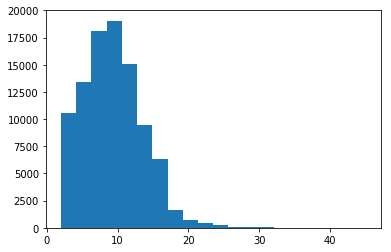

In [9]:
#lengths = [len(p['filtered_lists'][0]) for p in playlists]
lengths = [len(sl) for sl in playlists]
plt.hist(lengths, bins=20)
print('Average playlist length: %.1f' % np.mean(lengths))

Load `song_id` --> `track_id` mapping: a song may correspond to multiple tracks.

In [10]:
song2TrackID = pkl.load(open(fmap, 'rb'))

In [11]:
{ k : song2TrackID[k] for k in list(song2TrackID.keys())[:10] }

{'SOAAAFI12A6D4F9C66': ['TRZEXLQ128F1491D17'],
 'SOAAAMT12AB018C9C4': ['TRYIOYF12903CD4E73'],
 'SOAAASR12AB018A516': ['TRRTOHC12903CDD2EA'],
 'SOAABHX12AAF3B40E7': ['TRZARKN128F92DE096'],
 'SOAABLG12A6D4F73D2': ['TRFUCDA128F1455C96'],
 'SOAABMP12A6D4F7633': ['TRQVPBD128F1458060'],
 'SOAABMR12A6D4F70E4': ['TRVMASA128F149BB53'],
 'SOAABQL12A67020E76': ['TRJOVXI128E0791CFA'],
 'SOAABRB12A58A792A3': ['TRZGOQN128F935F425'],
 'SOAACBE12A6D4F7A54': ['TRHRWOM128F1466747']}

Load `song_id` --> `feature array` mapping: map a song to the audio features of one of its corresponding tracks in MSD.

In [13]:
song2Features = pkl.load(open(ffeature, 'rb'))

The set of songs, which is the set of labels in this formulation.

In [14]:
song_set = sorted(song2Features.keys())

In [15]:
len(song_set)

119466

In [16]:
label_indices = {songID: ix for ix, songID in enumerate(song_set)}

In [18]:
list(label_indices.items())[:10]

[('SOAAAFI12A6D4F9C66', 0),
 ('SOAAAMT12AB018C9C4', 1),
 ('SOAAASR12AB018A516', 2),
 ('SOAABHX12AAF3B40E7', 3),
 ('SOAABLG12A6D4F73D2', 4),
 ('SOAABMP12A6D4F7633', 5),
 ('SOAABMR12A6D4F70E4', 6),
 ('SOAABQL12A67020E76', 7),
 ('SOAABRB12A58A792A3', 8),
 ('SOAACBE12A6D4F7A54', 9)]

In [22]:
def gen_training_set(playlists=playlists, label_indices=label_indices, features=song2Features):
    """
        Create the labelled dataset for a given song index
        
        Input:
            - playlists: which playlists to create features for
            - label_indices: a dictionary that maps a songID to the index of the corresponding label
            - features: a dictionary that maps a songID to its feature vector
            
        Output:
            - (Feature, Label) pair (X, Y), with # num playlists rows
              X comprises the features for each seed song
              Y comprises the indicators of whether the given song is present in the respective playlist
    """

    N = len(playlists)
    K = len(label_indices)

    X = [ ]
    Y = lil_matrix((N, K), dtype=np.int8)
    
    cnt = 0
    for i in range(len(playlists)):
        cnt += 1
        if cnt % 10 == 0:
            sys.stdout.write('\r%d / %d' % (cnt, len(playlists)))
            sys.stdout.flush()
            
        playlist = playlists[i]
        seed     = playlist[0]

        X.append(features[seed])
        indices = [label_indices[s] for s in playlist]
        Y[i, indices] = 1

    return np.array(X), Y.tocsr()

## Training & Test

Train a logistic regression model for each label.

In [24]:
if np.all([os.path.exists(fname) for fname in [fxtrain, fytrain, fxtest, fytest]]):
    X_train = pkl.load(open(fxtrain, 'rb'))
    Y_train = pkl.load(open(fytrain, 'rb'))
    X_test  = pkl.load(open(fxtest,  'rb'))
    Y_test  = pkl.load(open(fytest,  'rb'))
else:
    X, Y = gen_training_set(playlists=playlists, label_indices=label_indices, features=song2Features)
    # by fixing random seed, the same playlists will be in the test set each time
    X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, Y, test_size=0.33, random_state=31)
    pkl.dump(X_train, open(fxtrain, 'wb'))
    pkl.dump(Y_train, open(fytrain, 'wb'))
    pkl.dump(X_test,  open(fxtest,  'wb'))
    pkl.dump(Y_test,  open(fytest,  'wb'))

95290 / 95298

In [25]:
X_train.shape

(63849, 91)

In [27]:
X_test.shape

(31449, 91)

In [29]:
def print_results(predictor, X_train, Y_train, X_test, Y_test):
    """
        Compute and save performance results
    """
    p3_train = []
    p5_train = []
    pk_train = []
    p10_train = []
    p3_test = []
    p5_test = []
    pk_test = []
    p10_test = []
    rankloss_train = []
    rankloss_test = []
    
    N_train = X_train.shape[0]
    batch_size = 500
    N_batch_train = int((N_train-1) / batch_size) + 1
    for i in range(N_batch_train):
        ix0 = i * batch_size
        ix1 = min((i+1) * batch_size, N_train)
        preds = predictor.decision_function(X_train[ix0:ix1])
        evaldict = evaluatePrecision(Y_train[ix0:ix1].toarray(), preds, verbose=-1)
        size = ix1 - ix0
        p3_train.append(evaldict['Precision@3'][0] * size)
        p5_train.append(evaldict['Precision@5'][0] * size)
        pk_train.append(evaldict['Precision@K'][0] * size)
        p10_train.append(evaldict['Precision@10'][0] * size)
        #rankloss_train.append(evalPred1(Y_train[i].toarray()[0], pred, metricType='Ranking'))
        sys.stdout.write('\r%d / %d' % (i+1, N_batch_train)); sys.stdout.flush()
    print()
    
    N_test = X_test.shape[0]
    N_batch_test = int((N_test-1) / batch_size) + 1
    for i in range(N_batch_test):
        ix0 = i * batch_size
        ix1 = min((i+1) * batch_size, N_test)
        preds = predictor.decision_function(X_test[ix0:ix1])
        evaldict = evaluatePrecision(Y_test[ix0:ix1].toarray(), preds, verbose=-1)
        size = ix1 - ix0
        p3_test.append(evaldict['Precision@3'][0] * size)
        p5_test.append(evaldict['Precision@5'][0] * size)
        pk_test.append(evaldict['Precision@K'][0] * size)
        p10_test.append(evaldict['Precision@10'][0] * size)
        #rankloss_test.append(evalPred1(Y_test[i].toarray()[0], pred, metricType='Ranking'))
        sys.stdout.write('\r%d / %d' % (i+1, N_batch_test)); sys.stdout.flush()
    print()
    
    print('Training set:')
    print('Precision@3:', (np.sum(p3_train) / N_train))
    print('Precision@5:', (np.sum(p5_train) / N_train))
    print('Precision@k:', (np.sum(pk_train) / N_train))
    print('Precision@10:', (np.sum(p10_train) / N_train))
    print()
    print('Test set:')
    print('Precision@3:', (np.sum(p3_test) / N_test))
    print('Precision@5:', (np.sum(p5_test) / N_test))
    print('Precision@k:', (np.sum(pk_test) / N_test))
    print('Precision@10:', (np.sum(p10_test) / N_test))
    
    #print()
    #print('Training set:')
    #print('RankingLoss: %.1f, %.1f' % (np.mean(rankloss_train), np.std(rankloss_train) / N_train))
    #print()
    #print('Test set:')
    #print('RankingLoss: %.1f, %.1f' % (np.mean(rankloss_test), np.std(rankloss_test) / N_test))

In [32]:
def print_dataset_info(X_train, Y_train, X_test, Y_test):
    N_train, D = X_train.shape
    K = Y_train.shape[1]
    N_test = X_test.shape[0]
    print('%-45s %s' % ('Number of training examples:', '{:,}'.format(N_train)))
    print('%-45s %s' % ('Number of test examples:', '{:,}'.format(N_test)))
    print('%-45s %s' % ('Number of features:', '{:,}'.format(D)))
    print('%-45s %s' % ('Number of labels:', '{:,}'.format(K)))
    avgK_train = np.mean(np.sum(Y_train, axis=1))
    avgK_test  = np.mean(np.sum(Y_test, axis=1))
    print('%-45s %.3f (%.3f%%)' % ('Average number of positive labels (train):', avgK_train, 100*avgK_train / K))
    print('%-45s %.3f (%.3f%%)' % ('Average number of positive labels (test):', avgK_test, 100*avgK_test / K))
    #print('%-45s %.4f%%' % ('Average label occurrence (train):', np.mean(np.sum(Y_train, axis=0)) / N_train))
    #print('%-45s %.4f%%' % ('Average label occurrence (test):', np.mean(np.sum(Y_test, axis=0)) / N_test))
    print('%-45s %.3f%%' % ('Sparsity (percent) (train):', 100 * np.sum(Y_train) / np.prod(Y_train.shape)))
    print('%-45s %.3f%%' % ('Sparsity (percent) (test):', 100 * np.sum(Y_test) / np.prod(Y_test.shape)))

In [33]:
print_dataset_info(X_train, Y_train, X_test, Y_test)

Number of training examples:                  63,849
Number of test examples:                      31,449
Number of features:                           91
Number of labels:                             119,466
Average number of positive labels (train):    9.365 (0.008%)
Average number of positive labels (test):     9.337 (0.008%)
Sparsity (percent) (train):                   0.008%
Sparsity (percent) (test):                    0.008%


Feature normalisation.

In [43]:
X_train_mean = np.mean(X_train, axis=0).reshape((1, -1))
X_train_std = np.std(X_train, axis=0).reshape((1, -1)) + 10 ** (-6)
X_train -= X_train_mean
X_train /= X_train_std
X_test  -= X_train_mean
X_test  /= X_train_std

In [47]:
X_train[100, :]

array([-0.08587364,  0.15145343,  3.03110687,  2.59613467, -0.14907683,
        2.18205533,  3.02430695,  2.59953993,  0.        ,  2.98921488,
       -0.15481325, -0.3191014 ,  0.        ,  1.60935991,  1.92890821,
        0.07342563,  0.61199962,  1.62396087,  0.0506255 ,  0.95249726,
        2.93187568,  2.59691981, -0.82399644, -0.55740981, -0.00419771,
       -0.09769548,  0.13280141,  0.00611655,  0.35663388, -0.39508608,
       -0.31072763,  0.15147666, -1.05652409, -0.09521882, -0.25287969,
       -1.01113434,  0.62712184, -1.25530744, -0.84926322, -1.47430381,
       -0.41517045,  1.76729269, -0.10973843,  1.31150192, -1.05265997,
       -0.01148716,  1.13640196, -1.13388668,  1.31349642, -1.02913882,
       -0.88649301, -1.39271767, -0.50997472,  1.97764296,  2.9232556 ,
        1.98521127,  0.13857995, -0.12739154,  1.06544479,  0.35167441,
       -0.33006219, -0.705186  ,  0.89579847, -0.03300568, -0.10806939,
       -0.32628819,  0.30145003,  0.31490025, -0.1426518 , -0.30

In [52]:
fbase = os.path.join(data_dir, 'aotm-2011/br_base_audio.pkl')
if os.path.exists(fbase):
    clf = pkl.load(open(fbase, 'rb'))
else:
    clf = OneVsRestClassifier(LogisticRegression(verbose=0), n_jobs=4)
    clf.fit(X_train, Y_train)
    pkl.dump(clf, open(fbase, 'wb'))

In [53]:
y1 = clf.decision_function(X_train[:1])[0]

In [64]:
Y_train[0].toarray().reshape(-1).nonzero()

(array([ 23897,  33199,  48775,  63175,  73862,  91000, 119146]),)

In [56]:
print_results(clf, X_train, Y_train, X_test, Y_test)

128 / 128
63 / 63
Training set:
Precision@3: 0.0266409810647
Precision@5: 0.0164074613541
Precision@k: 0.0114910557657
Precision@10: 0.00841203464424

Test set:
Precision@3: 0.0176052232715
Precision@5: 0.0105949314764
Precision@k: 0.00682441753198
Precision@10: 0.00531654424624


In [50]:
clf2 = TopPushMLC(C=1, r=1)
clf2.fit_SGD(X_train, Y_train, batch_size=500, n_epochs=10, learning_rate=0.01)

 128 / 128
epoch: 1 / 10, obj: 13.661346
 128 / 128
epoch: 2 / 10, obj: 11.840989
 128 / 128
epoch: 3 / 10, obj: 11.702071
 128 / 128
epoch: 4 / 10, obj: 11.691470
 128 / 128
epoch: 5 / 10, obj: 11.690662
 128 / 128
epoch: 6 / 10, obj: 11.690599
 128 / 128
epoch: 7 / 10, obj: 11.690594
 128 / 128
epoch: 8 / 10, obj: 11.690594
 128 / 128
epoch: 9 / 10, obj: 11.690594
 128 / 128
epoch: 10 / 10, obj: 11.690594


In [51]:
print_results(clf2, X_train, Y_train, X_test, Y_test)

128 / 128
63 / 63
Training set:
Precision@3: 0.0339290095903
Precision@5: 0.0275713010384
Precision@k: 0.0217161557304
Precision@10: 0.0201021159298

Test set:
Precision@3: 0.0313841457598
Precision@5: 0.0248720150084
Precision@k: 0.0187033232825
Precision@10: 0.0176921364749
